In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import operator 

%matplotlib inline

In [2]:
file_name = 'turnstile_171125.txt'
data = pd.read_csv(file_name, sep=",")

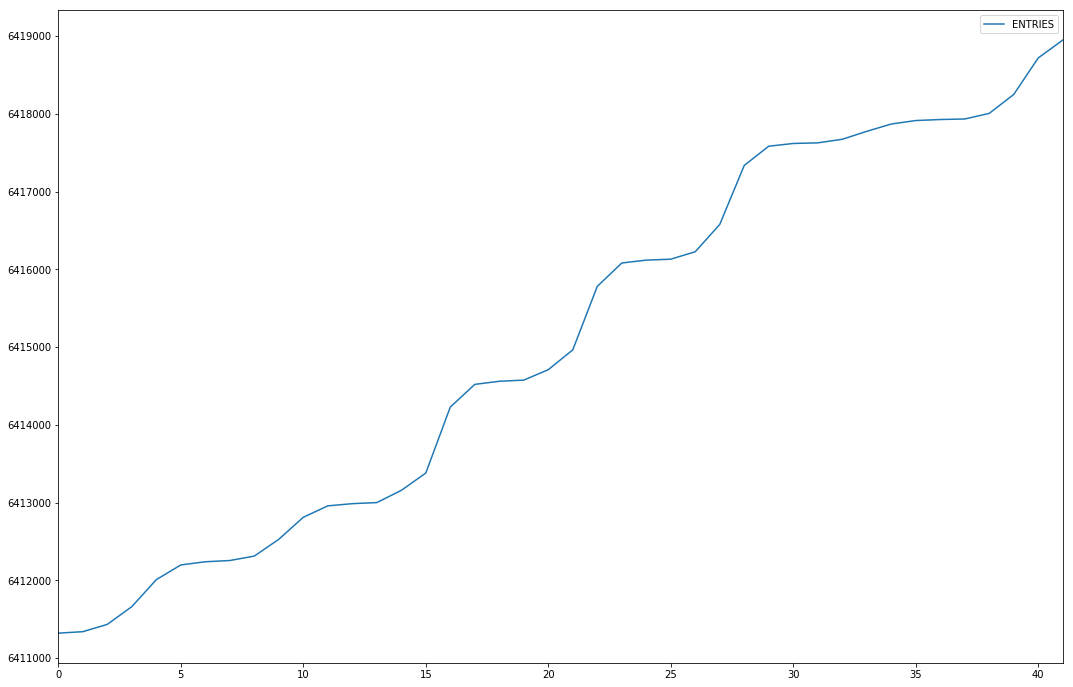

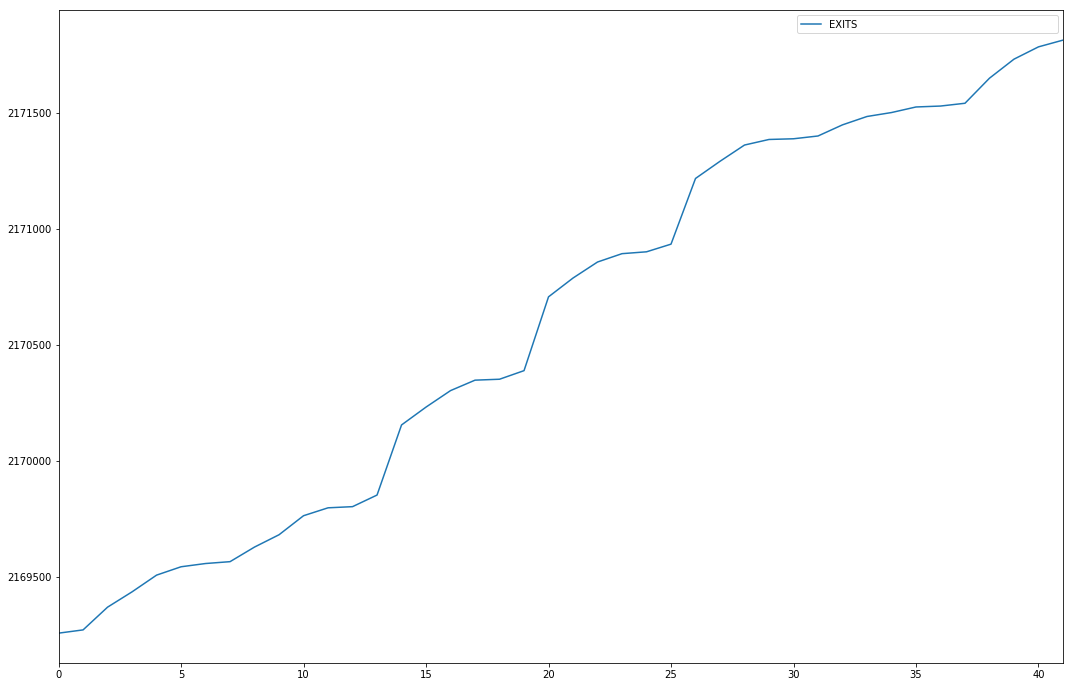

In [4]:
"""
    second part
    of extra credit
"""

# counters check
# get info about some example of grouped (!) data
# because it will be divided into groups according to the task
# by 'C/A' 'UNIT' and 'SCP'
# let it be 'A002' 'R051' and '02-00-00'
# DataFrame for ENTRIES
counters_check_df_en = data[(data['C/A'] == "A002") & (data['UNIT'] == "R051") & (data['SCP'] == '02-00-00')].iloc[:, -2:-1]
# DataFrame for EXITS
counters_check_df_ex = data[(data['C/A'] == "A002") & (data['UNIT'] == "R051") & (data['SCP'] == '02-00-00')].iloc[:, -1:]
# lets draw the relation between count of entries and num of observation
# and as it could be seen (screenshot 3 and screenshot 4)
# there is no any 'jumps' on the chart, it increases
# and it mean there are no counters which go down
counters_check_df_en.plot(figsize=(18, 12))
counters_check_df_ex.plot(figsize=(18, 12))

In [5]:
"""
    task 1
"""
# EXITS is the last column, it's faster and easier to get it and process in that way: just get last one
lcol = data.columns.tolist()[-1]
# rename it to simple 'EXITS' to remove extra trailing spaces
data = data.rename(columns={lcol: 'EXITS'})

# use method to_datetime to merge columns contain date and time to one column
# named DATE_TIME which contains a datetime object describes date and time both
data['DATE_TIME'] = pd.to_datetime(data['DATE'] + ' ' + data['TIME'])
# use set_index method to set index as in the task
data = data.set_index(['UNIT', 'C/A', 'SCP'])

In [6]:
"""
    task 2
"""
# use method groupby to group data by index defined in task
data = data.groupby(level=['UNIT', 'C/A', 'SCP'])

# create a new DataFrame object to store in all changed subgroups
DATA = pd.DataFrame()

# iterate data by subgroups
for i, group in data:
    # calculate necessary information for each subgroup as defined in the task
    group['NUM_ENTRIES'] = group.ENTRIES - group.ENTRIES.shift(1)
    group['NUM_EXITS'] = group.EXITS - group.EXITS.shift(1)

    # use fillna method to fill NaN values: all NaNs changes into rounded mean for
    # NUM_ENTRIES and NUM_EXITS columns
    group = group.fillna(group['NUM_ENTRIES':'NUM_EXITS'].mean().round(0))
    # use reset_index method to reset index
    # It's necessary to 'add' changed subgroup to our
    # whole DataFrame object named DATA we created early
    group.reset_index(inplace=True)
    # define DATA as result of concatenating old DATA value
    # and changed subgroup
    DATA = pd.concat([DATA, group])

# use set_index method to set index as in the task
DATA.set_index(keys=['UNIT', 'C/A', 'SCP', 'DATE_TIME'], inplace=True)
# reassign the data variable because it will be used below
data = DATA
# delete unnecessary more DATA variable
del DATA

In [7]:
"""
    task 3
"""

# regroup the data by using a resample method as defined in the task
# and apply an interpolate method
data = data[['NUM_ENTRIES', 'NUM_EXITS']].unstack(['UNIT', 'C/A', 'SCP']).resample('1H').interpolate(method='pchip')
# fill the NaN the same way as defined above
data = data.fillna(data.mean()['NUM_ENTRIES':'NUM_EXITS'].round(0))

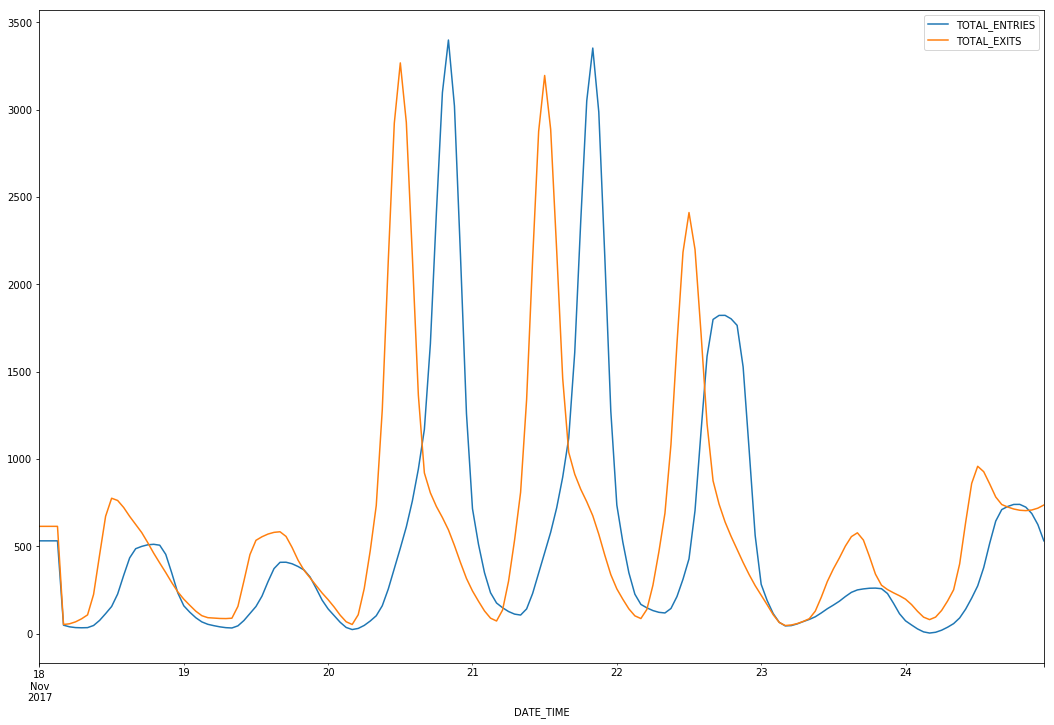

In [8]:
"""
    task 4
"""

# create an empty DataFrame object to experiment with
df = pd.DataFrame()
# define variables for experiments as given in the task
unit = 'R001'
ca = 'A058'

# make columns names to get information about entries and exits from
# certain columns
entries_name = ('NUM_ENTRIES', unit, ca)
exits_name = ('NUM_EXITS', unit, ca)

# make separate DataFrame for entries
d0 = data[entries_name]
# group by DATE_TIME
d0.groupby('DATE_TIME')
# calculate the total sum as defined in the task
d0['TOTAL_ENTRIES'] = d0.sum(axis=1)
# reassign the entries separated DataFrame
# to 'remove' columns we will not use
d0 = d0['TOTAL_ENTRIES']

# make separate DataFrame for exits
d1 = data[exits_name]
# group by DATE_TIME
d1.groupby('DATE_TIME')
# calculate the total sum as defined in the task
d1['TOTAL_EXITS'] = d1.sum(axis=1)
# reassign the exits separated DataFrame
# to 'remove' columns we will not use
d1 = d1['TOTAL_EXITS']

# the df DataFrame now contains the whole information
# about total sums entries and exits both
df = pd.concat([d0, d1], axis=1)
# plot results (screenshot 1)
df.plot(figsize=(18, 12))

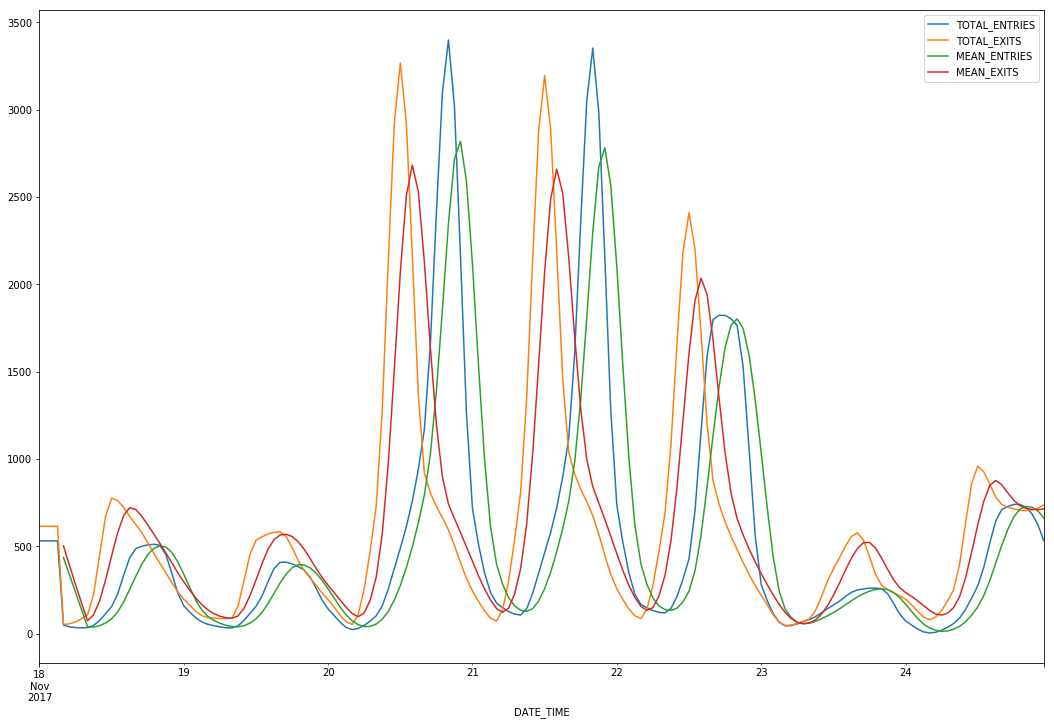

In [9]:
"""
    first part of
    extra credit (second part was at the top of this file)
"""

# create a new DataFrame for experiments as
# copying old df DataFrame to a new variable rolling
rolling = df
# use rolling mean method as defined in the task
# for both TOTAL_ENTRIES and TOTAL_EXITS columns
rolling['MEAN_ENTRIES'] = rolling['TOTAL_ENTRIES'].rolling(window=5).mean()
rolling['MEAN_EXITS'] = rolling['TOTAL_EXITS'].rolling(window=5).mean()

# plot results of using rolling mean method (screenshot 2)
rolling.plot(figsize=(18, 12))